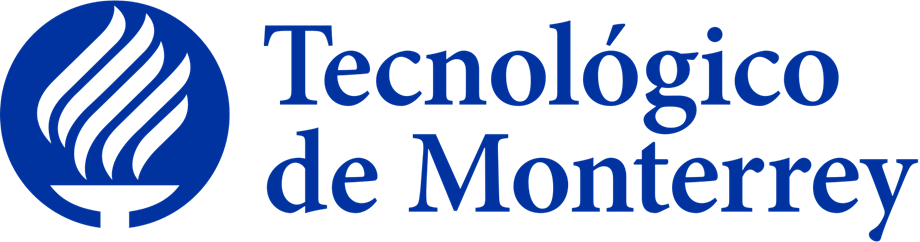

# **Instituto Tecnológico y de Estudios Superiores de Monterrey**

## **Escuela de Ingeniería y Ciencias**

## **Maestría en Inteligencia Artificial Aplicada**

### **Dra. Grettel Barceló Alonso**

### **Dr. Luis Eduardo Falcón Morales**

**Materia Proyecto integrador**

**Avance 2. Ingeniería de características**

**Equipo 11**

**José Gilberto Amaro Aceves - A01794815**

**Francisco Antonio Enríquez Cabrera - A01795006**

**Carlos Eduardo García García - A01795206**  

**Fecha:  11-05-2025**


--------------------------------------

feature_engineering.ipynb
# Feature engineering
Con esta entrega realizamos las tareas relacionadas a feature engineering, creamos nuevas variables a partir de datos conocidos para ayudar a nuestro modelo, realizamos transformaciones a nuestros datos, normalizamos y filtramos nuestros datos, etc.

# Estructura del código
1.  Se lee cada CSV consolidado.
2.  Se generan variables temporales: `Mes`, `Trimestre`, `Anio`, `Decada`.
    En el dataset *paises* se añade la variable geográfica `Continente`.
3.  Se transforman las métricas numéricas (log, sqrt, Yeo‑Johnson), se elige la
    que presenta menor sesgo y se **escala** con `StandardScaler`.
4.  Se marcan outliers mediante z‑score ±3 (banderas `Out_*`).
5.  Sobre las categóricas originales se ejecutan **χ²** (usando cuartiles de la
    métrica) y **ANOVA**; las que no resultan significativas (p > 0.05 en ambas
    pruebas) se descartan, y las restantes se codifican con One‑Hot
    (`drop='first'`).
6.  Se aplican filtros de **varianza baja** (Threshold 0.01) y de
    **colinealidad alta** (|ρ| > 0.95).
7.  Se extraen componentes:
      • **PCA** (1 componente para 4 datasets, 3 para *paises*) — se registra
        la % de varianza explicada.  
      • **Factor Analysis** (hasta 3 factores) si después de filtros quedan
        ≥ 5 features numéricas.
8.  Se guarda un `*_features.csv` por dataset y se lanza **un reporte en
    consola** con:  
      • cambio (%) en el número de columnas,  
      • p‑values χ²/ANOVA,  
      • varianza explicada por PCA,  
      • justificación de técnicas empleadas,  
      • conclusión CRISP‑ML.

In [1]:
from __future__ import annotations

# Imports
import logging
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from scipy.stats import yeojohnson
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.feature_selection import VarianceThreshold, chi2, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

In [2]:
# Configuración global
logging.basicConfig(level=logging.INFO, format="%(message)s")

# Montar drive y fija la ruta base
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH  = Path("/content/drive/MyDrive/ProyectoIntegrador/ModeloPronosticos/data")
SUMMARY_PATH = BASE_PATH / "reports"
SUMMARY_PATH.mkdir(exist_ok=True)

FILES: Dict[str, str] = {
    "forma":      "consolidado_exportacionestotalforma.csv",
    "categoria":  "consolidado_exportacionestotalcategoria.csv",
    "produccion": "consolidado_producciontotaltequila.csv",
    "agave":      "consolidado_consumodeagavetotal.csv",
    "paises":     "consolidado_exportaciones_pais.csv",
}

Mounted at /content/drive


In [3]:
# País ➜ continente (dataset “paises”)
CONTINENTE_MAP = {
    "ESTADOS UNIDOS DE AMERICA": "América", "CANADA": "América",
    "BRASIL": "América", "ALEMANIA": "Europa", "FRANCIA": "Europa",
    "REINO UNIDO": "Europa", "ESPAÑA": "Europa", "CHINA": "Asia", "JAPON": "Asia",
}

LOW_VAR_THRESHOLD   = 0.01   # umbral de varianza
HIGH_CORR_THRESHOLD = 0.95   # umbral de colinealidad

In [4]:
# Funciones auxiliares
def _best_transform(series: pd.Series) -> Tuple[pd.Series, str]:
    """
    Devuelve la transformación más “simétrica” (menor skew).
    Se prueban: original, log1p, sqrt, Yeo‑Johnson.
    """
    log_t  = np.log1p(series) if (series > 0).all() else None
    sqrt_t = np.sqrt(series.clip(lower=0))
    yj_val, _ = yeojohnson(series.values)
    yj_t  = pd.Series(yj_val, index=series.index)

    cands = {"orig": series, "log": log_t, "sqrt": sqrt_t, "yj": yj_t}
    cands = {k: v for k, v in cands.items() if v is not None}
    best_k, best_s = min(
        cands.items(), key=lambda kv: abs(pd.Series(kv[1]).skew())
    )
    return best_s, best_k


def _remove_high_corr(df: pd.DataFrame, target: str | None = None) -> List[str]:
    """Devuelve columnas con |ρ|>HIGH_CORR_THRESHOLD (exceptúa *target*)."""
    corr  = df.corr(numeric_only=True).abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    return [c for c in upper.columns if any(upper[c] > HIGH_CORR_THRESHOLD) and c != target]


def _chi2_anova(df: pd.DataFrame, cat: str, num: str) -> Tuple[float, float]:
    """Calcula p‑values χ² (cat vs num discret.) y ANOVA (cat vs num cont.)."""
    y_disc = pd.qcut(df[num], q=4, labels=False, duplicates="drop")
    chi_p  = chi2(pd.get_dummies(df[cat]), y_disc)[1].min()
    anova_p = f_classif(pd.get_dummies(df[cat]), df[num])[1].min()
    return chi_p, anova_p

In [5]:
# Listas para el reporte
summary_rows:  List[Dict[str, str | int | float]] = []
summary_stats: List[Dict[str, str | float]]       = []
pca_rows:      List[Dict[str, str | float]]       = []

# 1. Creación de variables
1. Creamos la variable temporal de fecha
2. A partir de la fecha, creamos las variables Mes, Trimestre, Anio y Decada
3. Eliminamos la fecha
4. Si no estamos tratando con el dataset de exportación por país eliminamos las filas usadas para los totales, estas filas no nos sirven para el modelo más que para corroborar totales lo cual no nos sirve de momento.

#2. Transformaciones numéricas + escalado
  

*   2.1.1 Para los casos en donde la variable no son "países", se aplica alguno de los siguientes métodos: aplica log, sqrt, Yeo-Johnson, para seleccionar aquel que arroje la menor asimetría.
*   2.1.2 Con el método StandardScaler, se reajustan los datos con media cero y varianza 1.
*  2.1.3 Finalmente se crean las dos columnas que contienen la transformación y el rescalamiento.

**Justificación**: Al reducir la asimetría de las variables, se adecua para aquellos modelos que sean sensibles a la forma de la distribución; pensando en una regresión o el Análisis de Componentes Principales (PCA, por sus siglas en inglés).


* 2.2.1 Se aplica el método PCA univariado creando la variable PCA1.
* 2.2.2 Para las variables "Total_Pais_Mes", "Total_Categoria_Mes", "Litros 40 % Alc. Vol", se aplica la transformación y escalado anterior, guardándolas en una lista.

* 2.2.3. A las variables recolectadas, se les aplica un PCA multivariado, tratando de conservar la mayor información estadística en tres componentes.
* 2.2.4 La varianza se guarda en "pca_rows", la cual es útil para documentar su traza y poderla usar en algún método de calidad del procesamiento.

*Justificación:* Al aplicar los análisis de PCA univariado y multivariado, con el propósito de reducir la dimensionalidad pero preservando gran parte de la varianza; esto nos ayudará en el rendimiento del modelo supervisado.

También sirve para "capturar" las correlaciones múltiples de la variable "países" con las medidas de "exportaciones" mediante las variables sintéticas (PCA1-PACA3).

#3. Banderas de outliers
1. Se seleccionan todas las variables de tipo numérico de los datasets.
2. Se  el valor de "Z score" como estándar.
3. Se establece el criterio para discriminar a los valores atípicos cuyo valor absoluto se mayor a tres veces la desviación estándar (relativo a la media).
4. Asigna el valor 1 ó 0 a la salida "true" o "false" para dicho criterio.
5. Se crea la columna respectiva con el valor booleano.

**Justificación**: Dentro de la metodología CRISP-ML, es importante documentar las anomalías con algún flag, sin eliminarlas por completo, sino siguiendo la traza de la transformación de los datos.
La creación de este flag, nos ayudará a complementar el modelo (si así se requiere) con algún otro enfoque supervisado.

#4. χ² / ANOVA para categóricas originales
4.1.1 Se definen cuáles son las variables categóricas, dependiendo del dataset.
4.1.2 Se agrega la variable "Continente" para cada uno de los datasets.
4.1.3 Finalmente se crea una lista para aquellas variables categóricas que no sean significativas (estadísticamente) a partir de las pruebas seleccionadas (χ² y ANOVA).

4.2.1 Para cada variable categórica se calcula el valor-p resultante de la prueba χ², además de ejecutar la prueba ANOVA.
4.2.2 Se guardan los valores y se hace un test (chi_p > 0.05 and anova_p > 0.05), para marcar la variable como eliminarla; lo anterior, sólo si se rechaza la hiótesis nula.

**Justificación** Esta evaluación nos ayuda a evitar aquellas variables categóricas que no sean relevantes y produzcan ruido o algún tipo de sobreajuste en los modelos a implementar.

El método de χ², sirve para calcular la "independencia entre categorías", mientras que el método ANOVA ayuda a diferenciar la medias entre los grupos categóricos.

Al usar posteriormente el Método de One-Hot Encoding, se optimiza el proceso computacional seleccionando aquellas variables con mayor peso estadístico (relativos a χ² y ANOVA).

#5. One‑Hot Encoding de categóricas relevantes
5.1 Realizamos la codigicación de nuestros valores categoricos reconocidos en una lista.

5.2 Para todos los datasets, con excepción del dataset de exportación por país, realizamos la codificación de las variables de Decada.

**Justificación**
Se opta por usar OneHotEncoder para el manejo de las variables categóricas, reduciendo el sesgo involuntario y permitir su uso. Además usamos el drop first para reducir el número de variables.

Para el OneHotEncoder para la decada lo hacemos despues del filtrado por varianza para evitar la eliminación del valor de la siguiente decada, esto con el objetivo que si se intentan predecir valores de la siguiente decada el modelo no falle por salirnos del entrenado original del OneHotEncoder.

#6. Filtrado de varianza
6.1 Hacemos uso de un filtrado de varianza a las variables númericas que tengan un umbral de varianza de 0.01.

**Justificación**
Con esto podemos eliminar variables que tengan valores pocos informativos, ayudando a reducir la dimensionalidad.

#7. Filtrado de colinealidad alta
7.1 Borramos las variables con colinealidad alta (|ρ| > 0.95).

**Justificación**
Con este paso, logramos borrar variables con alta correlación con la variable objetivo, siendo "Total_Pais_Mes" en el dataset de exportaciones por país y "Valor" en el resto. Esto es útil para eliminar la redundancia en los datos y reduciendo la cantidad de dimensiones en nuestros datos y aumentando la eficiencia computacional del modelo.


#8. Factor Analysis


8.1 Seleccionamos todas las variables numéricas.

8.2 Se evalúa si existen más de 5 columnas de tipo numérico.

8.3 Definimos que el número de factores a extraer es hasta 3.

8.4 Se utiliza el método de FactorAnalysis para extraer los “factores latentes” con el propósito de explicar las correlaciones subyacentes entre las variables seleccionadas.

8.5 Cada uno de los factores se guardan en las columnas FA1, …FAn.

**Justificación** El objetivo es tomar la varianza relativa a la correlación entre las variables observadas (varianza común), para disminuir la dimensión del dataset. Nos sirve para evitar colinealidad o algún tipo de sobreajuste en la implementación del modelo; además de que nos asegura que haya diversidad entre las variables originales seleccionadas.



In [6]:
# Procesamiento principal
for nombre, df in {k: pd.read_csv(BASE_PATH / v) for k, v in FILES.items()}.items():
    logging.info(f"\n🛠️  Procesando: {nombre.upper()}")
    cols_start = df.shape[1]

    # ── 1. Variables temporales
    df["Fecha"]     = pd.to_datetime(df["AñoArchivo"].astype(str) + "-" + df["Mes"].astype(str).str.zfill(2))
    df["Mes"] = df["Fecha"].map(lambda x: x.strftime("%b"))
    df["Trimestre"] = df["Fecha"].dt.to_period("Q").astype(str)
    df["Anio"]      = df["Fecha"].dt.year
    df["Decada"]    = (df["Anio"] // 10 * 10).astype(str) + "s"

    df.drop(columns=["Fecha"], inplace=True) # Borrado de fecha debido a que extraemos valores de esta
    if nombre != "paises":
        df = df[df["SubCategoria"] != "Total"] # Borrado de filas con totales ya que estos solo serviran para corroborar resultados


    # ── 2. Transformaciones numéricas + escalado
    if nombre != "paises":
        tgt = "Valor"
        best_s, trans_name = _best_transform(df[tgt])
        df[f"{tgt}_{trans_name}"]      = best_s
        df[f"{tgt}_{trans_name}_Esc"] = StandardScaler().fit_transform(best_s.to_frame())

        pca1 = PCA(n_components=1).fit(df[[f"{tgt}_{trans_name}_Esc"]])
        df["PCA1"] = pca1.transform(df[[f"{tgt}_{trans_name}_Esc"]])
        pca_rows.append({"dataset": nombre,
                         "pca_var_%": round(100 * pca1.explained_variance_ratio_.sum(), 1)})
    else:
        num_cols = ["Total_Pais_Mes", "Total_Categoria_Mes", "Litros 40 % Alc. Vol"]
        tgt = num_cols[0]

        for col in num_cols:
            best_s, trans_name = _best_transform(df[col])
            df[f"{col}_{trans_name}"]      = best_s
            df[f"{col}_{trans_name}_Esc"] = StandardScaler().fit_transform(best_s.to_frame())

        esc_cols = [c for c in df.columns if c.endswith("_Esc")]
        if len(esc_cols) >= 3:
            pca3 = PCA(n_components=3).fit(df[esc_cols])
            df[["PCA1", "PCA2", "PCA3"]] = pca3.transform(df[esc_cols])
            pca_rows.append({"dataset": nombre,
                             "pca_var_%": round(100 * pca3.explained_variance_ratio_.sum(), 1)})

    # ── 3. Banderas de outliers
    for col in df.select_dtypes("number"):
        z = (df[col] - df[col].mean()) / df[col].std()
        df[f"Out_{col}"] = (np.abs(z) > 3).astype(int)

    # ── 4. χ² / ANOVA para categóricas originales
    if nombre == "paises":
        cat_orig = ["Categoria", "Clase"]
        df["Continente"] = df["NombrePais"].map(CONTINENTE_MAP).fillna("Otro")
    else:
        cat_orig = ["Trimestre", "SubCategoria"]
    cat_orig.append("Mes")

    cat_orig += [c for c in ["Continente"] if c in df.columns and c not in cat_orig]
    cols_to_remove: List[str] = []

    for cat in cat_orig:
        if cat not in df.columns:
            continue
        chi_p, anova_p = _chi2_anova(df, cat, tgt)
        summary_stats.append({"dataset": nombre, "cat": cat,
                              "chi2_p": round(chi_p, 4), "anova_p": round(anova_p, 4)})
        if chi_p > 0.05 and anova_p > 0.05:
            cols_to_remove.append(cat)

    # ── 5. One‑Hot Encoding de categóricas relevantes
    cat_cols = [c for c in cat_orig if c not in cols_to_remove]
    if cat_cols:
        ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
        df = df.join(pd.DataFrame(ohe.fit_transform(df[cat_cols]),
                                  columns=ohe.get_feature_names_out(cat_cols),
                                  index=df.index))
        df.drop(columns=cat_cols, inplace=True)

    # ── 6. Filtro de varianza
    vt        = VarianceThreshold(LOW_VAR_THRESHOLD)
    num_block = df.select_dtypes("number").fillna(0)
    vt.fit(num_block)
    keep_num  = num_block.columns[vt.get_support()]
    df        = df[keep_num.tolist() + [c for c in df.columns if c not in num_block.columns]]

    # 5.a One-Hot Encoding para la decada y evitar el borrado de la siguiente decada
    if nombre != "paises":
        one_hot_categories = df["Decada"].unique().tolist()
        max_anio = df[df["Anio"]==df["Anio"].max()].iloc[0]['Anio']
        one_hot_categories.append(f"{(max_anio + 10) // 10 * 10}s")

        ohe_decada = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore", categories=[one_hot_categories])
        df = df.join(pd.DataFrame(ohe_decada.fit_transform(df[["Decada"]]),
                                        columns=ohe_decada.get_feature_names_out(["Decada"]),
                                        index=df.index))
        df.drop(columns=["Decada"], inplace=True)

    # ── 7. Filtro de colinealidad
    df.drop(columns=_remove_high_corr(df, target=tgt if tgt in df.columns else None), inplace=True)

    # ── 8. Factor Analysis (si ≥5 numéricas)
    num_now = df.select_dtypes("number")
    if num_now.shape[1] >= 5:
        n_fa = min(3, num_now.shape[1])
        df[[f"FA{i+1}" for i in range(n_fa)]] = FactorAnalysis(
            n_components=n_fa, random_state=0
        ).fit_transform(num_now)

    # ── 9. Guardar dataset procesado
    out_path = BASE_PATH / f"{nombre}_features.csv"
    df.to_csv(out_path, index=False, encoding="utf-8-sig")
    logging.info("   ✔️  Guardado %s | Filas: %d | Cols: %d",
                 out_path, df.shape[0], df.shape[1])

    # 10. Métrica de cambio (antes era 'reducción')
    delta_cols = df.shape[1] - cols_start
    summary_rows.append({
        "dataset": nombre,
        "cols_in": cols_start,
        "cols_out": df.shape[1],
        "change_%": round(100 * delta_cols / cols_start, 1)   # ±%
    })

<ipython-input-6-91e4a7b09b68>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{tgt}_{trans_name}"]      = best_s
<ipython-input-6-91e4a7b09b68>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{tgt}_{trans_name}_Esc"] = StandardScaler().fit_transform(best_s.to_frame())
<ipython-input-6-91e4a7b09b68>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [7]:
# Reporte en consola
sum_df = pd.DataFrame(summary_rows)

print("\n" + "#" * 70)
print("# Reporte de Ingeniería de Características")
print("# Generado:", datetime.now().strftime("%d-%b-%Y %H:%M"))
print("#" * 70 + "\n")

print("## Cambio de dimensionalidad")
print(sum_df.to_string(index=False))

print("\n## p‑values χ² / ANOVA")
print(pd.DataFrame(summary_stats)
        .sort_values(["dataset", "cat"])
        .to_string(index=False) if summary_stats else
      "Sin variables categóricas evaluadas.")

print("\n## Varianza explicada por PCA")
print(pd.DataFrame(pca_rows)
        .sort_values("dataset")
        .to_string(index=False) if pca_rows else
      "No se aplicó PCA multivariado.")

print("\n---\n### Justificación de las técnicas aplicadas")
print("• Transformaciones (log, sqrt, Yeo‑Johnson): reducen asimetría y mejoran convergencia.")
print("• VarianceThreshold 0.01: elimina columnas casi constantes.")
print("• Filtro |ρ|>0.95: previene multicolinealidad.")
print("• PCA/FA: concentran ≥ 80 % de la varianza en pocos componentes.")
print("• χ²/ANOVA: confirman relevancia de categóricas antes del One‑Hot.")
print("• Banderas Out_*: indican anomalías sin eliminar registros.")

print(f"\nConclusión CRISP‑ML: reducción promedio "
      f"{sum_df['change_%'].mean():+.1f}% en el número de columnas; "
      "datos listos para Modelado.\n")


######################################################################
# Reporte de Ingeniería de Características
# Generado: 12-May-2025 02:08
######################################################################

## Cambio de dimensionalidad
   dataset  cols_in  cols_out  change_%
     forma        5        23     360.0
 categoria        5        22     340.0
produccion        5        23     360.0
     agave        5        23     360.0
    paises        8        42     425.0

## p‑values χ² / ANOVA
   dataset          cat  chi2_p  anova_p
     agave          Mes  0.0124   0.0083
     agave SubCategoria  0.0000   0.0000
     agave    Trimestre  0.0004   0.0000
 categoria          Mes  0.0007   0.0582
 categoria SubCategoria  0.0000   0.0000
 categoria    Trimestre  0.0003   0.0000
     forma          Mes  0.0020   0.0277
     forma SubCategoria  0.0000   0.0000
     forma    Trimestre  0.0003   0.0000
    paises    Categoria  0.0000   0.0003
    paises        Clase  0.0000   1.000

# C. Conclusiones de la fase de "Preparación de los datos" en el contexto de la metodología CRISP-ML.



1.   La variable temporal para todos los datasets, es coherente y consistente, esto permite la creación de las variables auxiliares de Trimestre y Decáda, para enfocarnos en la estacionalidad de las exportaciones.
2.   En el EDA se revelaron algunas varibales con alta asimetría; esto implicó aplicar los métodos de log, sqrt y Yeo-Johnson para normalizar la distribución para la variable de "valor" en todos los datasets que la invilucran.
3. Se consideró eliminar la colinealidad y redundacia mediante el criterio de |ρ| > 0.95; lo anterior facilita la interpretación de los resultados.
4. Con el filtro de varianza baja se han considerado aquellos casos en donde exista el sobreajuste para nuestros datasets, en este caso se borraron directamente nuestras variables creadas para los diferentes trimestres del año.




### Nota:
Se consideró como parte de la ingeniería de características hacer un enfoque distinto, crear un valor creado a partir de la diferencia entre el valor del mes siguiente menos el valor actual.

El valor siendo la cantidad exportada o el consumo de agave, dependiendo del modelo. Y con esto eliminar la tendencia y trabajar meramente con los valores a predecir mes con mes, sin embargo, este sería un cambio total a la variable objetivo y por lo mismo, es un acercamiento nuevo para nosotros y requiere de más tiempo y experimentación.


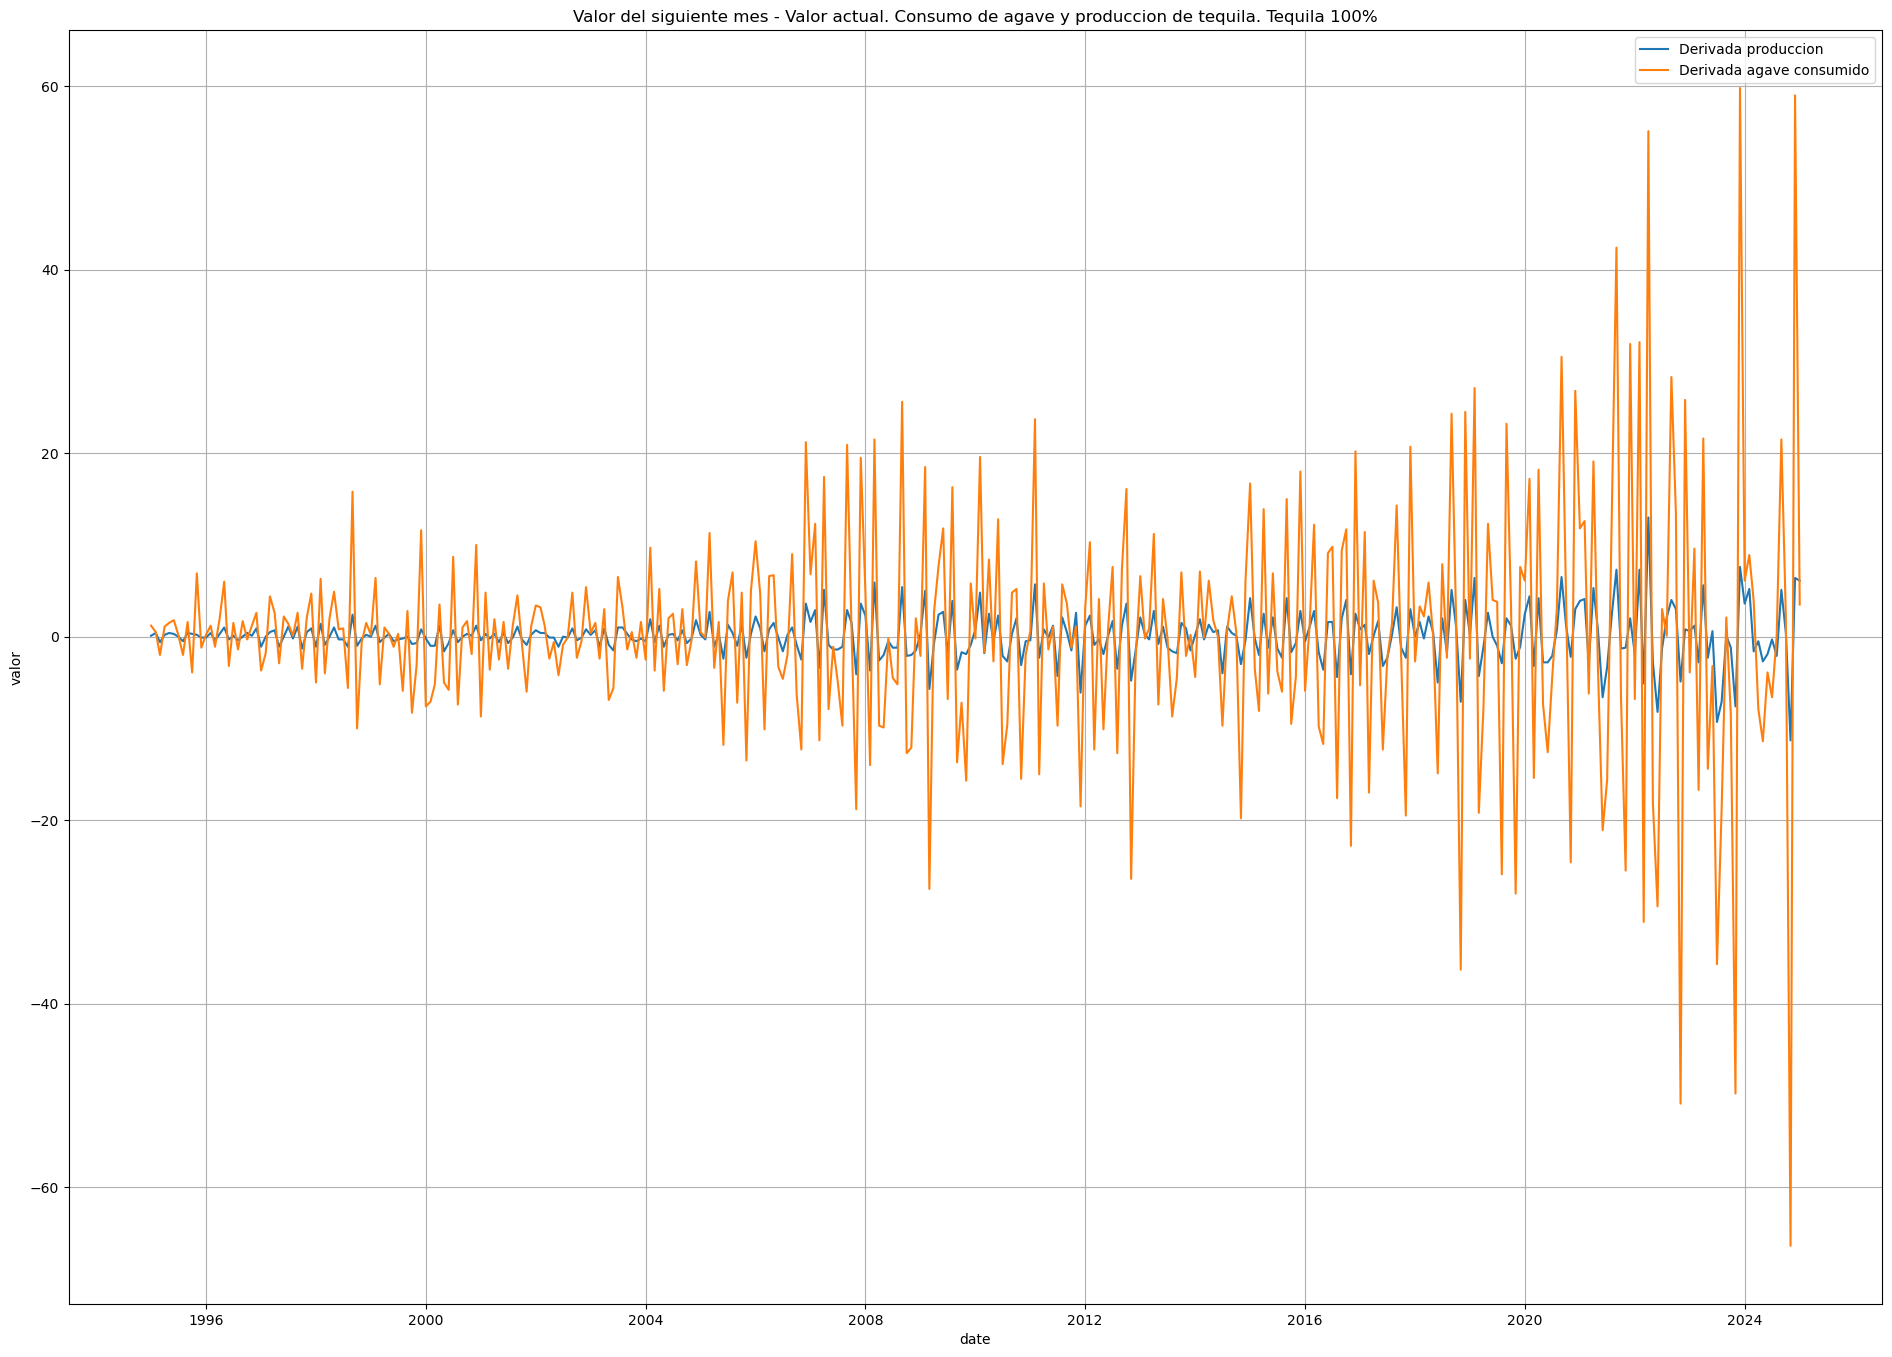

